# <center>Land Registry Data</center>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from datetime import datetime as dt
from scipy.stats import kruskal
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 400000)
pd.set_option("display.width", 1000)
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


nrows = 1000000

In [1]:
import plotly.graph_objects as go

mapbox_access_token = open(".mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
        lat=['38.91427','38.91538','38.91458',
             '38.92239','38.93222','38.90842',
             '38.91931','38.93260','38.91368',
             '38.88516','38.921894','38.93206',
             '38.91275'],
        lon=['-77.02827','-77.02013','-77.03155',
             '-77.04227','-77.02854','-77.02419',
             '-77.02518','-77.03304','-77.04509',
             '-76.99656','-77.042438','-77.02821',
             '-77.01239'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9
        ),
        text=["The coffee bar","Bistro Bohem","Black Cat",
             "Snap","Columbia Heights Coffee","Azi's Cafe",
             "Blind Dog Cafe","Le Caprice","Filter",
             "Peregrine","Tryst","The Coupe",
             "Big Bear Cafe"],
    ))

fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38.92,
            lon=-77.07
        ),
        pitch=0,
        zoom=10
    ),
)

fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '.mapbox_token'

In [2]:
# list of columns from the land registry site

column_list = ['TUI',
               'price',
               'date',
               'postcode',
               'property_type',
               'old/new',
               'duration',
               'PAON',
               'SAON',
               'street',
               'locality',
               'town/city',
               'district',
               'county',
               'ppd_category',
               'record_status']

post_codes = ['WD', 'EN', 'HA', 'IG', 'RM', 'DA', 'BR', 'CR', 'KT', 'TW', 'UB']
london_post_codes = ['E', 'WC', 'EC', 'N', 'NW', 'SE', 'SW', 'W']

In [3]:
# Reads in the property data CSV
main_df = pd.read_csv('pp-complete.csv', names=column_list)
print ('read property CSV'.title())

# Reads in the postcode data CSV
postcode_data = pd.read_csv('National_Statistics_Postcode_Lookup_UK.csv', usecols=['Postcode 1', 
                                                                                                 'Postcode 2',
                                                                                                 'Postcode 3', 
                                                                                                 'Easting', 
                                                                                                 'Northing', 
                                                                                                 'County Name', 
                                                                                                'Ward Name', 
                                                                                                'Lower Super Output Area Code', 
                                                                                                'Lower Super Output Area Name',
                                                                                                'Middle Super Output Area Name',
                                                                                                'Output Area Classification Name',
                                                                                                'Location'])
print ('read postcode CSV'.title())
# renames the useful postcode column to match the convention in the main_df otherwise we can't merge later
postcode_data = postcode_data.rename(columns={'Postcode 3': 'postcode'})


Read Property Csv
Read Postcode Csv


In [4]:
# Drops unneeded columns
main_df = main_df.drop(['TUI','district', 'record_status', 'locality', 'county'], axis=1 )
print ('Dropped columns'.title())

# Removes PPD Category Type 'B' to only leave residental sales
main_df = main_df.loc[main_df['ppd_category']  == 'A']
print ('removed non-residental sale data'.title())

# Converts price to an integer
main_df['price'] = main_df['price'].apply(int)
print ('Converted prices to integers'.title())

# Removes outliers 
main_df = main_df.loc[(main_df['price'] >= 75000) & (main_df['price'] <= 1000000)]
print ('Removed outliers'.title())

# Creates a datetime object for the 'date' column, and creates columns for month and year sold. 
main_df['date_sold'] = pd.to_datetime(main_df['date'], format='%Y-%m-%d %H:%M')
print ('converted date_sold'.title())
main_df['year_sold'] = main_df['date_sold'].dt.year
print ('converted year'.title())
# main_df['month_sold'] = main_df['date'].dt.strftime('%m')
# print ('converted_month'.title())
# main_df['date_sold'] = main_df['date'].dt.strftime('%Y-%m')


main_df = main_df.drop(['date'], axis=1)
print ('DateTime objects created'.title())

# converts postcodes to strings, and slices just the first two characters
main_df['postcode'] = main_df['postcode'].apply(str)
# .apply(lambda x: x[:2])
# removes the numbers from single digit postcodes 
# main_df['postcode'] = main_df['postcode'].filter(lambda x: x.isalpha(), x)
print ('Converted Postcodes'.title())

# Formats the MSOA and LSOA column
postcode_data['Middle Super Output Area Name'] = postcode_data['Middle Super Output Area Name'].apply(lambda x: x.replace(" ", ""))
postcode_data['Lower Super Output Area Name'] = postcode_data['Lower Super Output Area Name'].apply(lambda x: x.replace(" ", ""))


# Fills NaN Values
main_df = main_df.fillna(0)
print ('Removed NaN Values'.title())

# Creates a full address column
main_df['address'] = main_df['postcode'].astype(str) + main_df['street'].astype(str) + main_df['SAON'].astype(str) + main_df['PAON'].astype(str)
main_df['address'] = main_df['address'].apply(lambda x: x.replace(" ", ""))
main_df['address'] = main_df['address'].apply(lambda x: x.lower())
print ('Created Address Column')

# Drops unneeded columns
main_df = main_df.drop(['PAON', 'SAON', 'street', 'ppd_category'], axis=1 )
print ('Dropped address columns'.title())

main_df = main_df.reset_index(drop=True)
print('reset that naughty index'.title())

main_df.head(5)

budget_min = 200000
budget_max = 300000

# Always ensures that the year we check against is always the most recent available in the dataset
# Stops me having to guess the last year when we load in different numbers of rows from the .csv
year_to_check = main_df['year_sold'].max()



Dropped Columns
Removed Non-Residental Sale Data
Converted Prices To Integers
Removed Outliers
Converted Date_Sold
Converted Year
Datetime Objects Created
Converted Postcodes
Removed Nan Values
Created Address Column
Dropped Address Columns
Reset That Naughty Index


,price,postcode,property_type,old/new,duration,town/city,date_sold,year_sold,address
0,95000,WS14 0BE,D,N,F,LICHFIELD,1995-09-22,1995,ws140behalllane0foxcovercottage
1,96000,KT17 2DU,S,N,F,EPSOM,1995-10-27,1995,kt172dukingstonroad082
2,425000,KT11 1HP,D,N,F,COBHAM,1995-03-31,1995,kt111hpbrunswickgrove018
3,89995,WF6 2TT,D,Y,F,NORMANTON,1995-06-30,1995,wf62ttshawavenue08
4,105000,OX17 1JU,D,N,F,BANBURY,1995-08-31,1995,ox171juhoggend08


In [5]:
full_merged_df = pd.merge(main_df, postcode_data[['postcode', 'County Name', 'Ward Name', 'Lower Super Output Area Name', 'Middle Super Output Area Name']], on='postcode', how='left').sort_values('address')

full_merged_df = full_merged_df.rename(columns={'County Name': 'county_name', 'Ward Name': 'ward_name', 'Lower Super Output Area Name': 'LSOA', 'Middle Super Output Area Name': 'MSOA'})

full_merged_df.head(5)

,price,postcode,property_type,old/new,duration,town/city,date_sold,year_sold,address,county_name,ward_name,LSOA,MSOA
5101144,177000,AL10 0AB,S,N,F,HATFIELD,2003-10-10,2003,al100ablongmead01,Hertfordshire,Hatfield Central,WelwynHatfield010F,WelwynHatfield010
18483614,360000,AL10 0AB,T,N,F,HATFIELD,2019-10-11,2019,al100ablongmead017,Hertfordshire,Hatfield Central,WelwynHatfield010F,WelwynHatfield010
13657858,240000,AL10 0AB,T,N,F,HATFIELD,2014-01-31,2014,al100ablongmead017,Hertfordshire,Hatfield Central,WelwynHatfield010F,WelwynHatfield010
5915844,185000,AL10 0AB,T,N,F,HATFIELD,2004-09-06,2004,al100ablongmead019,Hertfordshire,Hatfield Central,WelwynHatfield010F,WelwynHatfield010
13022716,220000,AL10 0AB,T,N,F,HATFIELD,2013-01-24,2013,al100ablongmead019,Hertfordshire,Hatfield Central,WelwynHatfield010F,WelwynHatfield010


In [6]:
rounded = full_merged_df.copy()

rounded['price'] = rounded['price'].apply(lambda x: round(x, -4))




# probability distribution

# cdf - cumulative distribution frequency 

# box plot

In [7]:
london = full_merged_df.loc[full_merged_df['county_name'] == 'Inner London'][['county_name', 'price']]

london = london.groupby('price').count().reset_index()

london = london.rename(columns={'county_name': 'count'})


In [8]:
london['houses_running_total'] = london['count'].cumsum()
total = london['count'].sum()
total


london['percentage'] = london['houses_running_total'] / total * 100

london.head(5)

1080860

,price,count,houses_running_total,percentage
0,75000,3867,3867,0.357771
1,75002,1,3868,0.357863
2,75030,1,3869,0.357956
3,75045,1,3870,0.358048
4,75050,2,3872,0.358233


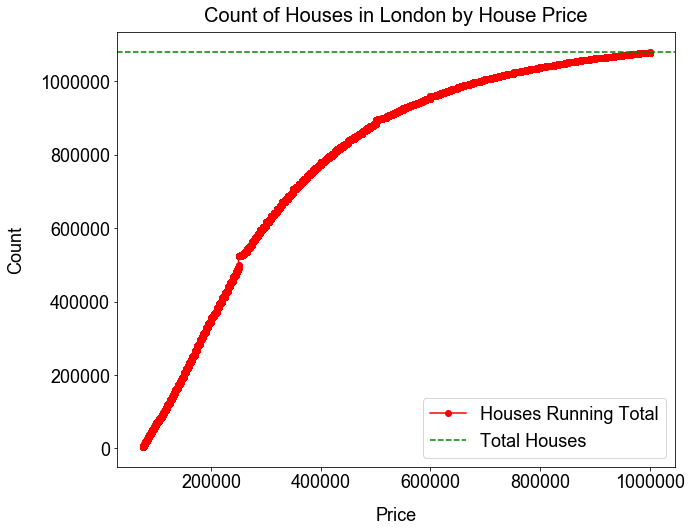

In [9]:
london.plot(x='price', y='houses_running_total', kind='line',
            figsize=(10,8), legend=False, style='ro-', 
            label='houses running total'.title())

plt.axhline(y=total, color='green', linestyle='--', label='Total Houses')
plt.title('Count of Houses in London by House Price', y=1.01, fontsize=20)
plt.ylabel('Count', labelpad=15)
plt.xlabel('Price', labelpad=15)
plt.legend();

48.53931128915863


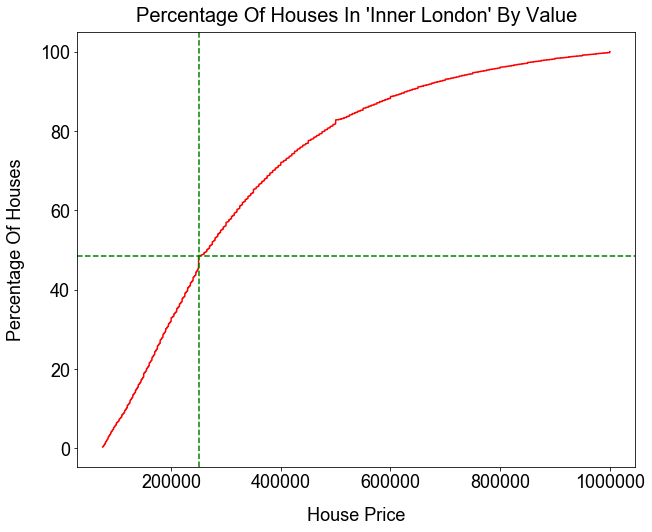

In [10]:
price = 250000
intersect_val = float(london['percentage'].loc[london['price'] == price])
print (intersect_val)

london.plot(x='price', y='percentage', kind='line', figsize=(10,8), legend=False, style='r')
plt.title("Percentage of houses in 'Inner London' by value".title(), y=1.01, fontsize=20)
plt.ylabel('percentage of houses'.title(), labelpad=15)
plt.xlabel('House Price', labelpad=15)
plt.axvline(x=price, color='green', linestyle='--')
plt.axhline(y=intersect_val, color='green', linestyle='--')




plt.show();

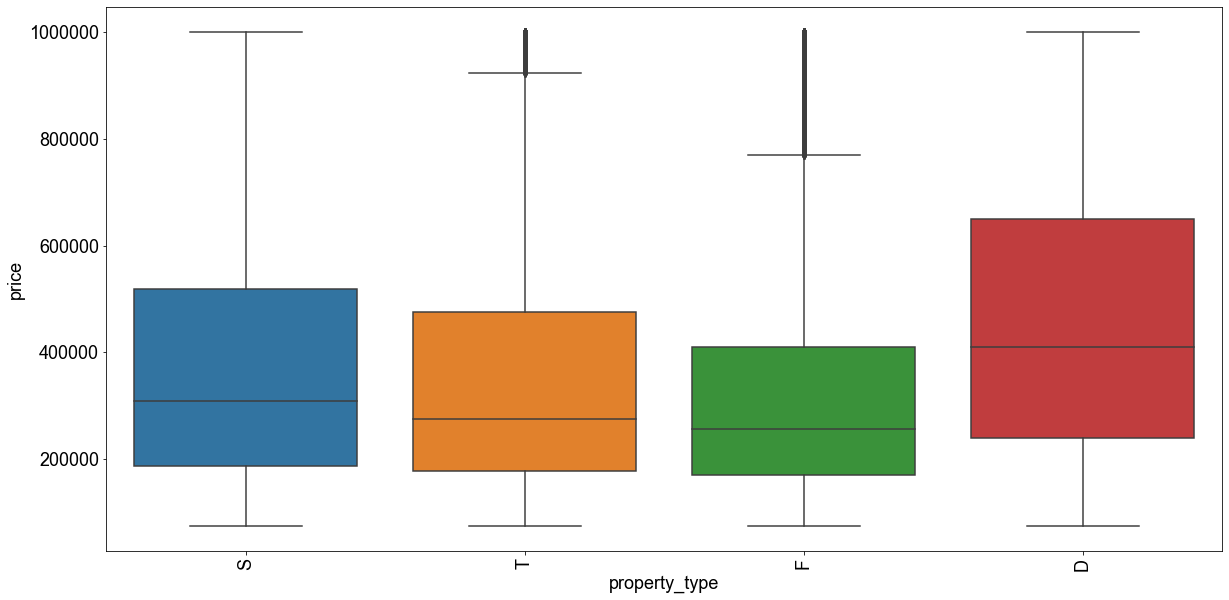

In [11]:
# full_merged_df.boxplot(column=['price'], grid=False)

chart = sns.boxplot(data=full_merged_df.loc[full_merged_df['county_name'] == 'Inner London'], x='property_type', y='price')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

plt.show();






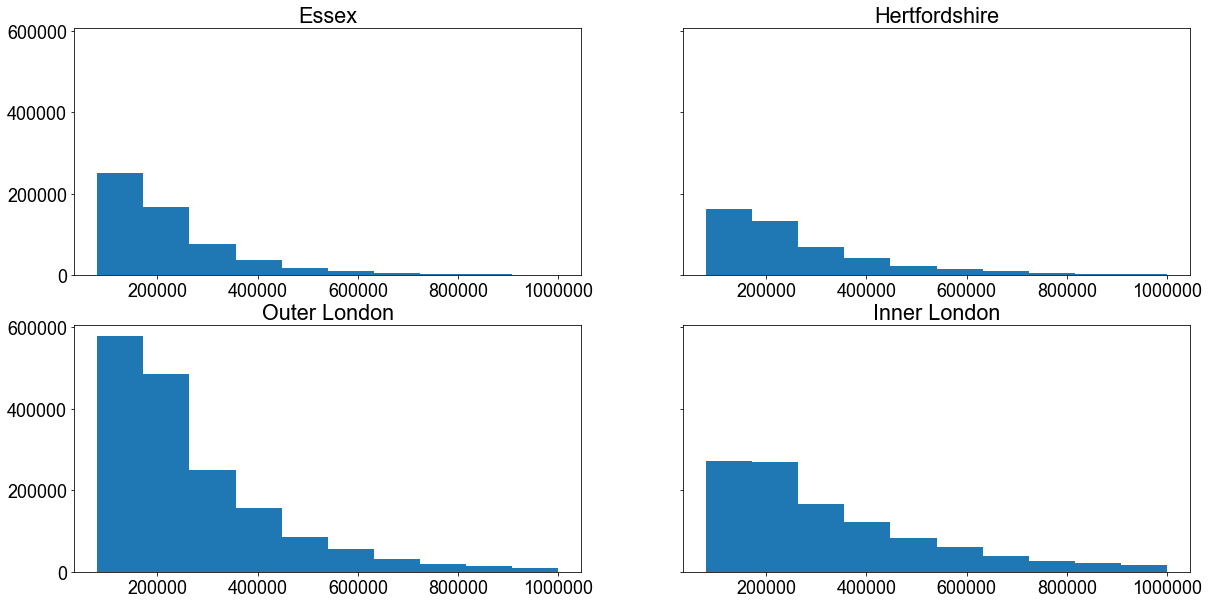

In [12]:
counties = ['Essex', 'Hertfordshire', 'Outer London', 'Inner London']


fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True)
for ax, county in zip(axes.flatten(), counties):
    df = rounded.loc[rounded['county_name'] == county];
    
    ax.hist(df['price'], bins=10)
    ax.set(title=county.title())

plt.show();

               £200k to £300k  £300k to £400k  £400k to £500k  £500k to £600k
Essex                    2487            1963             829             405
Hertfordshire             944            1382             909             568
Outer London             2245            3951            3544            2090
Inner London              613            1495            1710            1121


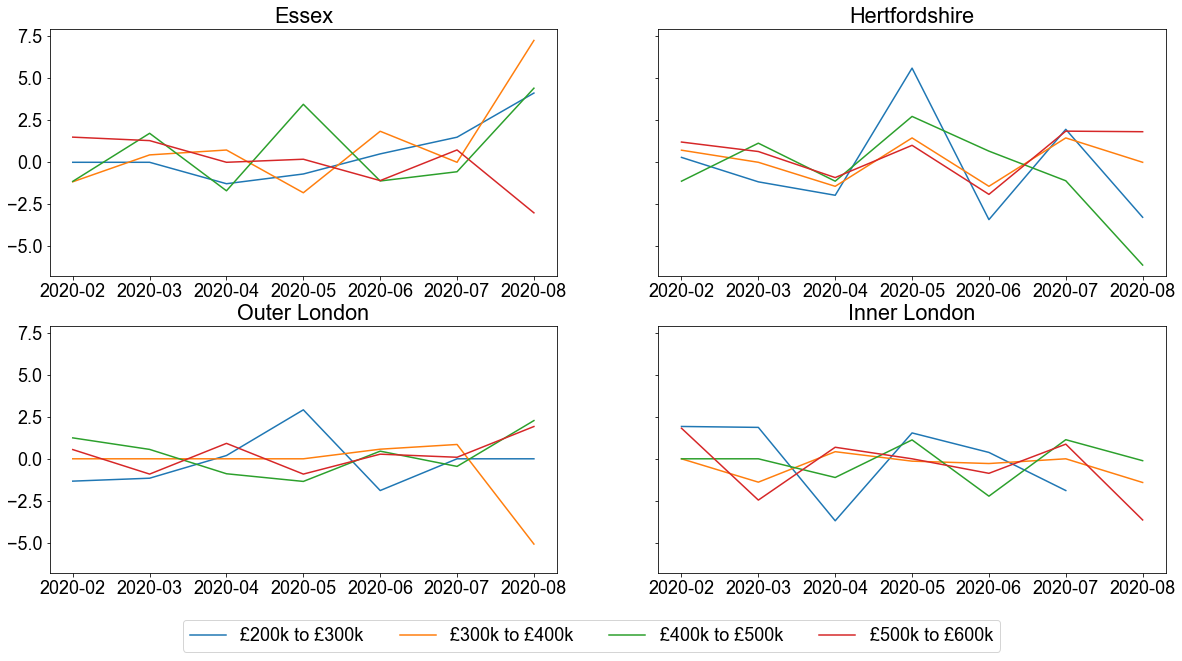

In [13]:
year_start = 2020
year_end = 2020

fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=False)
n_table = []

for ax, county in zip(axes.flatten(), counties):  
    
    df = full_merged_df.loc[(full_merged_df['year_sold'] >= year_start) &
                     (full_merged_df['year_sold'] < year_end + 1) &
                     (full_merged_df['county_name'] == county)].copy()
    
    df['year_month_sold'] = df['date_sold'].apply(lambda x: x.strftime("%Y-%m"))

    legend_list = []
    
    step = 100000
    price_range = range(200000, 600000, step)


    n_list = []
    for price in price_range:
        
        min = price
        max = price + step
        
        title = ("£" + str(min)[:-3] + "k to " + "£" + str(max)[:-3] + 'k')
        legend_list.append(title)

        vals = df.loc[(df['price'] > price) & (df['price'] < price + step)]
        n = len(vals)
        vals = vals.groupby('year_month_sold')['price'].median().reset_index()
        
        n_list.append(n)
        

        
        x_vals = vals['year_month_sold']
        y_vals = (((vals['price'] - vals['price'].shift()) / vals['price'].shift())) * 100
        
        
        ax.plot(x_vals, y_vals)
        ax.set(title=county.title())     
            
        
    n_table.append(n_list)

n_table_df = pd.DataFrame(n_table, index=counties, columns=legend_list)
print (n_table_df)
plt.figlegend(legend_list, loc = 'lower center', ncol=5, labelspacing=0. )
plt.show();



In [14]:
# Removes properties not in London or in the surrounding postcodes
main_df = main_df.loc[(main_df['postcode'].apply(lambda x: x[0:2]).isin(post_codes)) | (main_df['town/city'] == 'LONDON')]

# New Dataframe containing only the address of properties that were in budget for past N years
address_df = main_df.loc[(main_df['price'] > budget_min) & (main_df['price'] < budget_max) & (main_df['year_sold'] > (year_to_check - 2))]
address_list = list (address_df['address'].values)

# Exclues properties that do not match an address in address_df 
main_df = main_df.loc[main_df['address'].isin(address_list)]

# Creates a list of properties that have been sold 2 or more times. 
sold_twice_list = main_df[main_df['address'].isin(main_df['address'].value_counts()[main_df['address'].value_counts() >= 2].index)].address

# Matches properties in main_df that have been sold twice or more.
main_df = main_df.loc[main_df['address'].isin(sold_twice_list)]

# Creates a list of properties that have multiple property types 
multiple_property_type_list = list (main_df.groupby('address')['property_type'].nunique()[main_df.groupby('address')['property_type'].nunique() >= 2].index)

# Removes properties in that list from the final DF
final_df = main_df.loc[~main_df['address'].isin(multiple_property_type_list)]

only_affordable = final_df.reset_index()

lst = list (only_affordable.sort_values('price', ascending=False)['address'])

only_affordable.head(5)



,index,price,postcode,property_type,old/new,duration,town/city,date_sold,year_sold,address
0,2697,112500,HA9 8JZ,S,N,F,WEMBLEY,1995-08-01,1995,ha98jzprestonroad045
1,12777,82950,KT10 0AW,F,Y,L,ESHER,1995-02-08,1995,"kt100awmanorroadnorthflat49gibsoncourt,33"
2,16875,97500,EN2 0AE,T,N,F,ENFIELD,1995-06-30,1995,en20aemonasterygardens034
3,29254,84000,TW17 8EF,F,N,L,SHEPPERTON,1995-02-16,1995,tw178eflalehamroad10claremont
4,49065,83950,DA7 4HJ,F,Y,L,BEXLEYHEATH,1995-03-31,1995,"da74hjeaststreetflat3ferncourt,11"


In [15]:
merged_df = pd.merge(only_affordable, postcode_data[['postcode', 'County Name', 'Ward Name', 'Lower Super Output Area Name', 'Middle Super Output Area Name']], on='postcode', how='left').sort_values('address')

merged_df = merged_df.rename(columns={'County Name': 'county_name',
                                      'Ward Name': 'ward_name',
                                      'Lower Super Output Area Name': 'LSOA',
                                      'Middle Super Output Area Name': 'MSOA'})

merged_df.head(5)

,index,price,postcode,property_type,old/new,duration,town/city,date_sold,year_sold,address,county_name,ward_name,LSOA,MSOA
22244,18589605,299995,BR1 1BQ,F,N,L,BROMLEY,2019-10-18,2019,br11bqnorthstreetflat35newmancourt,Outer London,Bromley Town,Bromley018B,Bromley018
2288,3516639,248950,BR1 1BQ,F,N,L,BROMLEY,2002-08-23,2002,br11bqnorthstreetflat35newmancourt,Outer London,Bromley Town,Bromley018B,Bromley018
15748,17597054,245000,BR1 1RE,F,N,L,BROMLEY,2018-07-10,2018,br11reweststreet053b,Outer London,Bromley Town,Bromley008B,Bromley008
20981,18446791,226500,BR1 1RE,F,N,L,BROMLEY,2019-06-07,2019,br11reweststreet053b,Outer London,Bromley Town,Bromley008B,Bromley008
23342,18711122,275000,BR1 1RH,F,N,L,BROMLEY,2020-06-03,2020,"br11rhsouthstreetflat8southstreetstudios,1",Outer London,Bromley Town,Bromley018B,Bromley018


In [16]:
# Creates a total change groupby object that then gets reset into a dataframe
grouped_addr = merged_df.groupby(['address', 'property_type', 'postcode', 'county_name', 'ward_name', 'LSOA', 'MSOA']).agg(min_price=('price', 'min'),
                                                                              year_sold_min=('date_sold', 'min'),
                                                                              max_price=('price', 'max'),
                                                                              year_sold_max=('date_sold', 'max'),
                                                                              price_diff=('price', lambda x: (x.max() - x.min())),
                                                                              year_diff=('date_sold', lambda x: (((x.max() - x.min()).days) / 365)))

grouped_addr = grouped_addr.reset_index()

# Removes any entries that were sold in the same year or had their value increase
grouped_addr = grouped_addr.loc[(grouped_addr['price_diff'] != 0) & (grouped_addr['year_diff'] >= 1)]

# Number of decimal places in round()
n = 2

# Rounds the years diff column value to 2 decimal places
# Not possible to do within the .agg function it seems
grouped_addr['year_diff'] = grouped_addr['year_diff'].round(n)

# Total price change per year
grouped_addr['price_change_per_year'] = (grouped_addr['price_diff'] / grouped_addr['year_diff']).round(n)

# Total percentage change
grouped_addr['pct_change_total'] = ((((grouped_addr['max_price'] - grouped_addr['min_price']) / grouped_addr['min_price']) * 100)).round(n)

# Percentage change per year
grouped_addr['pct_change_per_year'] = (grouped_addr['pct_change_total'] / grouped_addr['year_diff']).round(n)

grouped_addr.head(5)

,address,property_type,postcode,county_name,ward_name,LSOA,MSOA,min_price,year_sold_min,max_price,year_sold_max,price_diff,year_diff,price_change_per_year,pct_change_total,pct_change_per_year
0,br11bqnorthstreetflat35newmancourt,F,BR1 1BQ,Outer London,Bromley Town,Bromley018B,Bromley018,248950,2002-08-23,299995,2019-10-18,51045,17.16,2974.65,20.50,1.19
2,"br11rhsouthstreetflat8southstreetstudios,1",F,BR1 1RH,Outer London,Bromley Town,Bromley018B,Bromley018,275000,2017-02-09,285000,2020-06-03,10000,3.32,3012.05,3.64,1.10
3,br12bttheavenueflat316,F,BR1 2BT,Outer London,Bickley,Bromley016C,Bromley016,187500,2006-05-19,295000,2019-12-13,107500,13.58,7916.05,57.33,4.22
4,br12bysouthlandsgroveflat20windsorcourt,F,BR1 2BY,Outer London,Bickley,Bromley020A,Bromley020,195000,2015-07-07,250000,2019-08-13,55000,4.10,13414.63,28.21,6.88
5,br12bysouthlandsgroveflat9windsorcourt,F,BR1 2BY,Outer London,Bickley,Bromley020A,Bromley020,160000,2008-02-08,275000,2020-05-26,115000,12.30,9349.59,71.88,5.84


In [17]:
ward_groupby = merged_df.loc[merged_df['year_sold'] > 2018].groupby('ward_name').agg(count=('address', 'count')).sort_values('count', ascending=False)
ward_groupby = ward_groupby.reset_index()


more_than_30 = ward_groupby[ward_groupby['count'] >= 15]

# list (more_than_30['Ward Name'])

grave = merged_df.loc[merged_df['ward_name'] == 'Gravesham']
grave


,index,price,postcode,property_type,old/new,duration,town/city,date_sold,year_sold,address,county_name,ward_name,LSOA,MSOA


In [18]:
# best_performing_pct_change_median_names = list (grouped_addr.groupby(['Ward Name'])['pct_change_per_year'].median().sort_values(ascending=False).head(5).index)

# median_pct_across_years = grouped_addr.groupby(['Ward Name', 'year_sold'])[['pct_change_per_year']].median().reset_index()
# median_pct_across_years.head(5)

In [19]:
def find_best_area(dataset, area, target, n=10, year_min=None, year_max=None):
    if year_max == None:
        year_max = dataset['year_sold_max'].max()
    if year_min == None:
        year_min = dataset['year_sold_min'].min()
    else:
        pass
    
    dataset = dataset[(dataset['year_sold_min'] > year_min) & (dataset['year_sold_max'] < year_max)]
    
    group = dataset.groupby(area)[target].median().sort_values(ascending=False).head(n)

    figure = plt.bar(group.index, group, width=0.8)
    plt.xticks(rotation=75)
    plt.title(f'Top {n} Median {target} for {area} between {year_min.year} and {year_max.year}'.replace("_", " ").title())

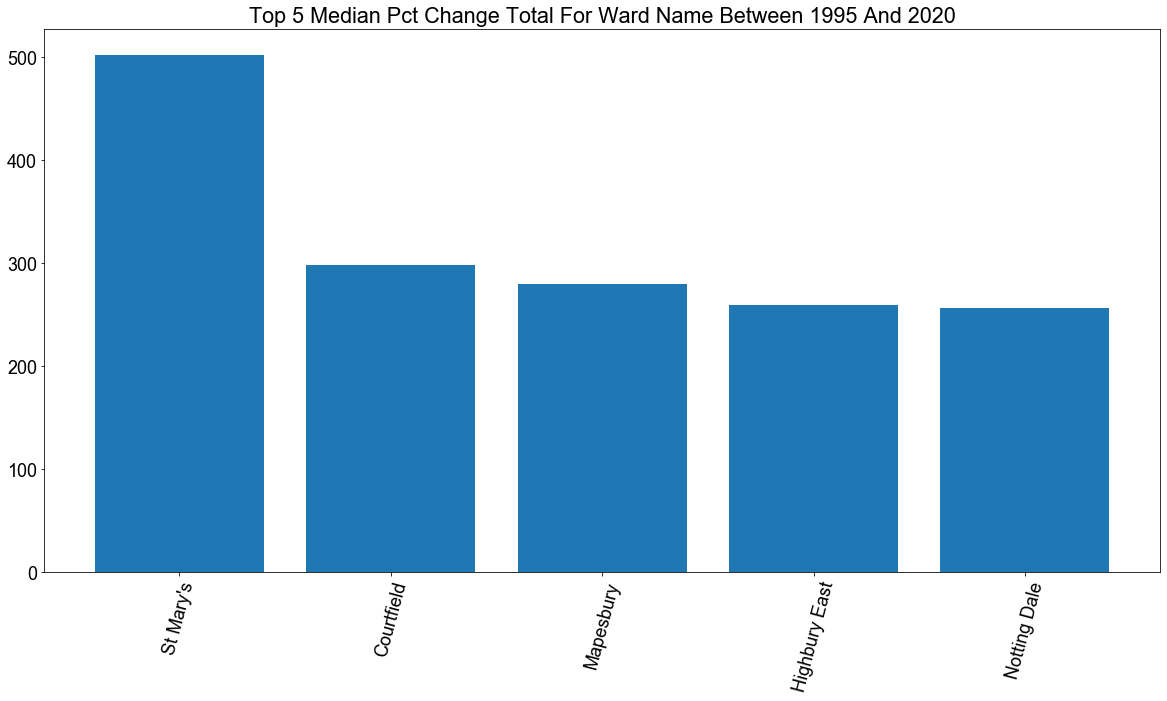

In [20]:
find_best_area(dataset=grouped_addr, area='ward_name', target='pct_change_total', n=5)

In [21]:
grouped_addr.head(5)

,address,property_type,postcode,county_name,ward_name,LSOA,MSOA,min_price,year_sold_min,max_price,year_sold_max,price_diff,year_diff,price_change_per_year,pct_change_total,pct_change_per_year
0,br11bqnorthstreetflat35newmancourt,F,BR1 1BQ,Outer London,Bromley Town,Bromley018B,Bromley018,248950,2002-08-23,299995,2019-10-18,51045,17.16,2974.65,20.50,1.19
2,"br11rhsouthstreetflat8southstreetstudios,1",F,BR1 1RH,Outer London,Bromley Town,Bromley018B,Bromley018,275000,2017-02-09,285000,2020-06-03,10000,3.32,3012.05,3.64,1.10
3,br12bttheavenueflat316,F,BR1 2BT,Outer London,Bickley,Bromley016C,Bromley016,187500,2006-05-19,295000,2019-12-13,107500,13.58,7916.05,57.33,4.22
4,br12bysouthlandsgroveflat20windsorcourt,F,BR1 2BY,Outer London,Bickley,Bromley020A,Bromley020,195000,2015-07-07,250000,2019-08-13,55000,4.10,13414.63,28.21,6.88
5,br12bysouthlandsgroveflat9windsorcourt,F,BR1 2BY,Outer London,Bickley,Bromley020A,Bromley020,160000,2008-02-08,275000,2020-05-26,115000,12.30,9349.59,71.88,5.84


In [22]:
# Creates a yearly change groupby object that then gets reset into a dataframe
grouped_postcode_yearly = merged_df.groupby(['address','property_type', 'postcode', 'county_name', 'ward_name', 'MSOA', 'LSOA', 'year_sold', 'price']).median()

grouped_postcode_yearly = grouped_postcode_yearly.reset_index().drop(columns='index')


# Creates columns
grouped_postcode_yearly['prev_price'] = grouped_postcode_yearly.groupby('address')['price'].shift()
grouped_postcode_yearly['price_diff'] = grouped_postcode_yearly['price'] - grouped_postcode_yearly['prev_price']
grouped_postcode_yearly['pct_change'] = (((grouped_postcode_yearly['price'] - grouped_postcode_yearly['prev_price']) / grouped_postcode_yearly['prev_price']) * 100)
grouped_postcode_yearly['prev_year'] = grouped_postcode_yearly.groupby('address')['year_sold'].shift()
grouped_postcode_yearly['year_diff'] = grouped_postcode_yearly['year_sold'] - grouped_postcode_yearly['prev_year']
# Filters NaN values 
grouped_postcode_yearly['prev_price'] = np.where(np.isnan(grouped_postcode_yearly['prev_price']), 0, grouped_postcode_yearly['prev_price'])
grouped_postcode_yearly['price_diff'] = np.where(np.isnan(grouped_postcode_yearly['price_diff']), 0, grouped_postcode_yearly['price_diff'])
grouped_postcode_yearly['prev_year'] = np.where(np.isnan(grouped_postcode_yearly['prev_year']), 0, grouped_postcode_yearly['prev_year'])
grouped_postcode_yearly['year_diff'] = np.where(np.isnan(grouped_postcode_yearly['year_diff']), 0, grouped_postcode_yearly['year_diff'])
grouped_postcode_yearly['pct_change'] = np.where(np.isnan(grouped_postcode_yearly['pct_change']), 0, grouped_postcode_yearly['pct_change'])

# Removes entries with a zero price diff or zero year diff
grouped_postcode_yearly = grouped_postcode_yearly.loc[(grouped_postcode_yearly['price_diff'] != 0) & (grouped_postcode_yearly['year_diff'] >= 1)]



In [23]:
grouped_postcode_yearly.groupby('county_name').median()

,year_sold,price,prev_price,price_diff,pct_change,prev_year,year_diff
county_name,,,,,,,
(pseudo) England (UA/MD/LB),2019,222000,149995.0,62852.5,43.116930,2006.0,6.0
Essex,2019,224000,160000.0,55000.0,31.818182,2007.0,5.0
Hertfordshire,2019,227500,163000.0,51240.0,32.829303,2007.0,6.0
Inner London,2019,250000,160000.0,66500.0,43.478261,2007.0,7.0
Kent,2019,234000,160000.0,57877.5,38.029851,2008.0,6.0
Outer London,2019,239000,160000.0,60000.0,38.888889,2007.0,6.0
Surrey,2019,231000,174950.0,45000.0,26.914661,2007.0,6.0


In [24]:
def median_change_across_time(dataset, area, target, subtarget=None, n=5):
    global year_to_check
    

    if subtarget == None:
        pass
    
#     if area == 'County Name':
#         if subtarget in (list (dataset[area])):
#             dataset = dataset.loc[dataset[area] == subtarget]
#             area = 'Ward Name'
#     if area == 'Ward Name':
#         if subtarget in (list (dataset[area])):
#             dataset = dataset.loc[dataset[area] == subtarget]
#             area = 'postcode'
#             print ('postcode')

    if n < 0:
        names = dataset.groupby([area, 'year_sold'])[target].median().reset_index().groupby(area)[target].sum().sort_values(ascending=True)

    if n > 0:
        names = dataset.groupby([area, 'year_sold'])[target].median().reset_index().groupby(area)[target].sum().sort_values(ascending=False)
    
    names = list (names.head(abs(n)).index)

    df = dataset.groupby([area, 'year_sold'])[target].median().reset_index()
    figure = plt.subplots()
    for name in names:
        
        vals = df[df[area] == name][target]
        years = df[df[area] == name]['year_sold']
        plt.plot(years, vals)

    plt.legend(names)
    plt.title( f'Median {target} from 1995 to {year_to_check} for {area}'.title().replace("_", ' '))
    plt.xticks(range(1995, year_to_check, 2))
    return figure
    
    
        

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbdbca54a50>)

,address,property_type,postcode,county_name,ward_name,MSOA,LSOA,year_sold,price,prev_price,price_diff,pct_change,prev_year,year_diff
8031,e48hfwalthamway08,F,E4 8HF,Outer London,Valley,WalthamForest006,WalthamForest006A,2006,165000,89995.0,75005.0,83.343519,2001.0,5.0
8032,e48hfwalthamway08,F,E4 8HF,Outer London,Valley,WalthamForest006,WalthamForest006A,2015,250000,165000.0,85000.0,51.515152,2006.0,9.0
8033,e48hfwalthamway08,F,E4 8HF,Outer London,Valley,WalthamForest006,WalthamForest006A,2019,282500,250000.0,32500.0,13.000000,2015.0,4.0
8035,e48hyhalllane0276a,T,E4 8HY,Outer London,Valley,WalthamForest006,WalthamForest006B,1997,105000,78000.0,27000.0,34.615385,1996.0,1.0
8036,e48hyhalllane0276a,T,E4 8HY,Outer London,Valley,WalthamForest006,WalthamForest006B,1999,118000,105000.0,13000.0,12.380952,1997.0,2.0
8037,e48hyhalllane0276a,T,E4 8HY,Outer London,Valley,WalthamForest006,WalthamForest006B,2019,244400,118000.0,126400.0,107.118644,1999.0,20.0
8039,e48jdmandevillecourt097,F,E4 8JD,Outer London,Valley,WalthamForest006,WalthamForest006B,2020,223500,94000.0,129500.0,137.765957,2002.0,18.0
8050,"e48llchingfordmountroadflat36kingswoodcourt,175",F,E4 8LL,Outer London,Valley,WalthamForest006,WalthamForest006C,2001,112000,79450.0,32550.0,40.969163,1998.0,3.0
8051,"e48llchingfordmountroadflat36kingswoodcourt,175",F,E4 8LL,Outer London,Valley,WalthamForest006,WalthamForest006C,2007,195000,112000.0,83000.0,74.107143,2001.0,6.0
8052,"e48llchingfordmountroadflat36kingswoodcourt,175",F,E4 8LL,Outer London,Valley,WalthamForest006,WalthamForest006C,2008,205000,195000.0,10000.0,5.128205,2007.0,1.0


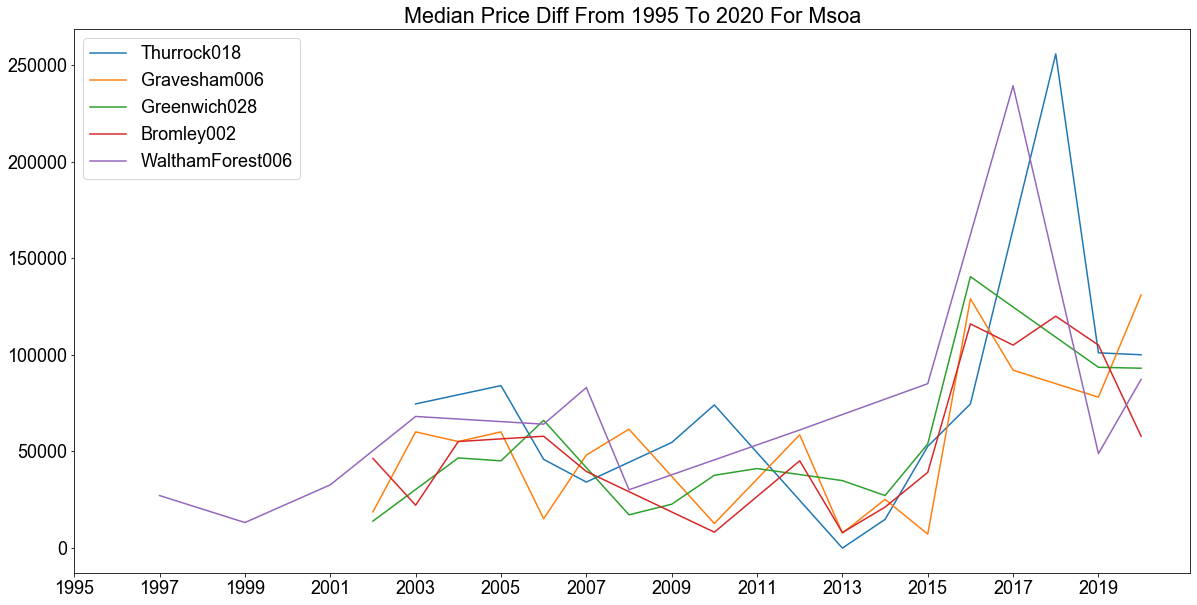

In [25]:
median_change_across_time(grouped_postcode_yearly, n=5, area='MSOA', target='price_diff')



grouped_postcode_yearly.loc[grouped_postcode_yearly['MSOA'] == 'WalthamForest006']

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbd4c28b650>)

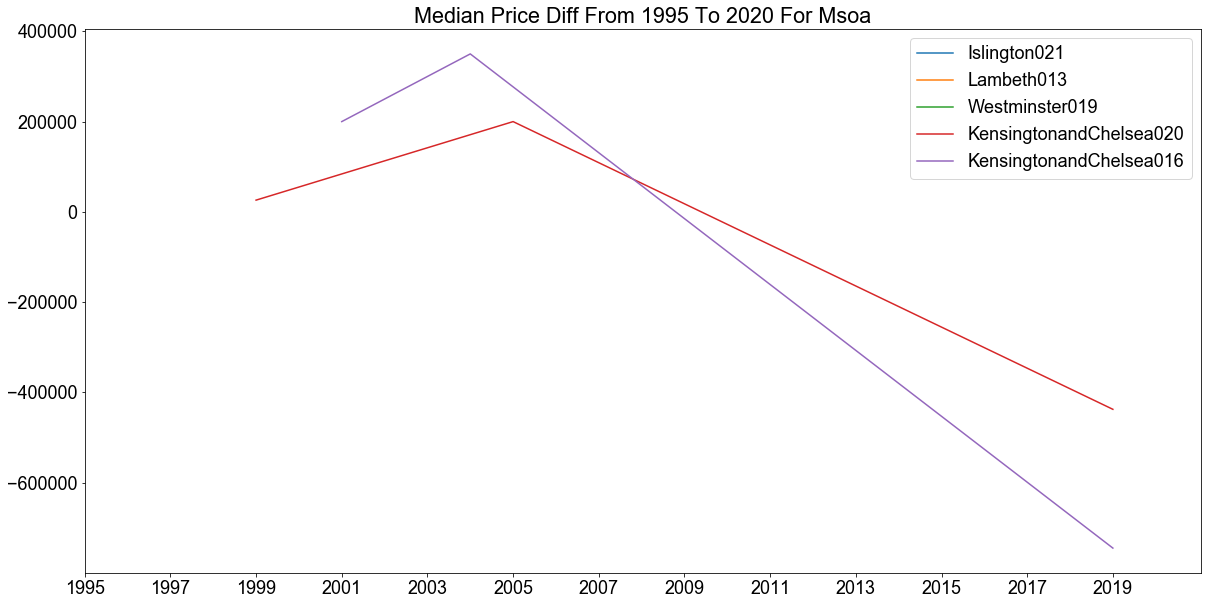

In [26]:
median_change_across_time(grouped_postcode_yearly, n=-5, area='MSOA', target='price_diff', subtarget='Outer London')

In [27]:
# grouped_postcode_yearly.loc[grouped_postcode_yearly['Ward Name'] == 'South Richmond']

In [28]:
i = 0
top_postcode = grouped_addr['postcode'].value_counts().index[i]
most_popular = grouped_addr[grouped_addr['postcode'] == top_postcode]
top_type = most_popular['property_type'].value_counts().index[0]

top_postcode, top_type

('RM7 0FT', 'F')

In [2]:
def prediction(dataset, postcode, property_type, year_bought, year_to_sell):
    try:
        type_dict = {'F': 'Flat', 'T': 'Terraced House', 'S': 'Semi-Detached House', 'D': 'Detached House'}

        year_bought = dt.strptime(str(year_bought), '%Y')
        year_to_sell = dt.strptime(str(year_to_sell), "%Y")

        df = dataset[(dataset['postcode'] == postcode) & (dataset['property_type'] == property_type) & (dataset['year_sold_min'] > year_bought) & (dataset['year_sold_max'] < year_to_sell)]
        model = LinearRegression()

        x = df['year_diff']
        y = df['price_change_per_year']
        x = x.values.reshape(-1, 1)
        y = y.values.reshape(-1, 1)

    #     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.8, train_size = 0.2)

        model.fit(x, y)

        x_predict = np.array((year_to_sell - year_bought).days / 365).reshape(-1, 1)

        y_predict = model.predict(np.array(pd.date_range('2012-04-23', '2013-01-23', freq='BM')))

        plt.scatter(x, y)
        plt.scatter(x_predict, y_predict, color='r', marker='x')
        plt.xlabel('Years Owned')
        plt.ylabel('Price')
        plt.title(f'Predicted sale price if you held a {type_dict.get(property_type)} in \"{postcode}\" from {year_bought.year} to {year_to_sell.year}'.title())

        print (y_predict)
    except ValueError:
        print ('Not enough samples, please use larger dataset.')



    
prediction(grouped_addr, top_postcode, top_type, 2001, 2020)
    

NameError: name 'grouped_addr' is not defined

In [30]:
def prediction_2(dataset, postcode, property_type, year_bought, price_bought, year_to_sell=2020):
    type_dict = {'F': 'Flat', 'T': 'Terraced House', 'S': 'Semi-Detached House', 'D': 'Detached House'}
    
#     year_bought = dt.strptime(str(year_bought), '%Y')
    
    df = dataset[(dataset['postcode'] == postcode) & 
                 (dataset['property_type'] == property_type) & 
                 (dataset['year_sold'] >= year_bought) & 
                 (dataset['price'] < price_bought) & 
                 (dataset['price'] < price_bought)]
    model = LinearRegression()
    

    x = df['year_sold']
    y = df['price']
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    
    model.fit(x, y)

    x_predict = np.array(year_to_sell).reshape(-1, 1)

    y_predict = model.predict(x_predict)

    plt.scatter(x, y)
    plt.scatter(x_predict, y_predict, color='r', marker='x')
    
    plt.xlabel('Year Sold')
    plt.title(f'Predicted price if you sold a {type_dict[property_type]} in \"{postcode}\" in {year_to_sell} that was bought in {year_bought}'.title())




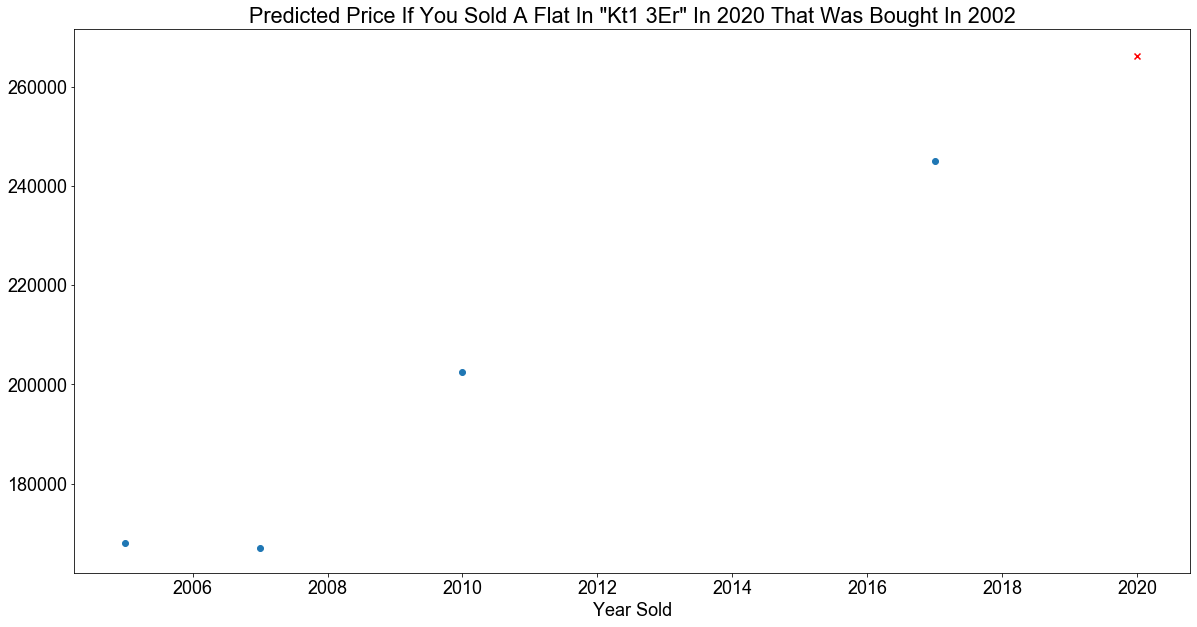

In [31]:
prediction_2(dataset=grouped_postcode_yearly, postcode='KT1 3ER', property_type='F', year_bought=2002, price_bought=250000, year_to_sell=2020)


In [32]:
grouped_postcode_yearly.loc[grouped_postcode_yearly['postcode'] == 'KT1 3ER'].sort_values('year_sold').head(2)

,address,property_type,postcode,county_name,ward_name,MSOA,LSOA,year_sold,price,prev_price,price_diff,pct_change,prev_year,year_diff
11688,kt13erkingsworthyclose049,F,KT1 3ER,Outer London,Norbiton,KingstonuponThames005,KingstonuponThames005C,2005,168000,120000.0,48000.0,40.000000,2000.0,5.0
11693,kt13erkingsworthyclose05,F,KT1 3ER,Outer London,Norbiton,KingstonuponThames005,KingstonuponThames005C,2007,167000,135000.0,32000.0,23.703704,2003.0,4.0
